# Heart Disease Classification Report

## 1. Introduction

### 1.1 Background
Cardiovascular diseases (CVDs), especially heart disorders, are a primary cause of death worldwide, according to the World Health Organization. 

The aim of this project is to answer the following question: **Is heart disease present (values = 1, 2, 3, 4) or absent (value = 0) in a new patient?**

### 1.2 Data set
To answer this question, we will analyze data downloaded from the UCI Machine Learning Repository. Below, we read the Cleveland dataset into `heart_disease_dataset`. Each row in the data set contains data about one patient. We will add a column `presence` (the predicted attribute) to indicate the presence or absence of heart disease. 

Relevant columns in the dataset:

- `age` - age in years
- `sex` - sex (1 = male; 0 = female)
- `cp` - chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
- `chol` - serum cholestoral in mg/dl
- `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- `restecg` - resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `thalach` - maximum heart rate achieved
- `exang` - exercise induced angina (1 = yes; 0 = no)
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- `ca` - number of major vessels (0-3) colored by flourosopy
- `thal` - 3 = normal; 6 = fixed defect; 7 = reversable defect
- `presence` - predicted attribute (1,2,3,4 - yes and 0 - no)

## 2. Methods & Results


### 2.1 Loading libraries & Setting Seed

In [1]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(GGally)
library(ggplot2)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

-- Attaching packages -------------------------------------- tidymodels 0.1.4 --

v broom        0.7.10     v rsample      0.1.1 
v dials        0.0.10     v tune         0.1.6 
v infer        1.0.0      v workflows    0.2.4 
v modeldata    0.1.1      v workflowsets 0.1.0 
v parsnip      0.1.7      v yardstick    0.0.9 
v recipes      0.1.17     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks

In [2]:
set.seed(999) # reproducible

### 2.2 Reading, Cleaning, and Wrangling Data

We will start by reading in the data using the URL, adding column names, following the necessary pre-processing steps on the dataset, and splitting the dataset into training and testing dataset. Will will then conduct some Exploratory data analysis using visualisations on training data and ggpairs to figure out which attributes will be essential in our classification model. 

- Assign column names `age`, `sex`, `cp`, `trestbps`, `chol`, `fbs`, `restecg`, `thalach`, `exang`, `oldpeak`, `slope`, `ca`, `thal`, `presence`.
- Select only `age`, `trestbps`, `chol`, `thalach`, `oldpeak` (non-categorical variables), and `presence` (predicted attribute as a factor) columns.
- Filter out any rows containing NA or invalid value.
- Shuffle rows of the data frame for a more representative randomly ordered data set to remove any bias due to the ordering of the rows in the dataset.
- Scale all the features being used in Classification to get them on the same scale

After preprocessing the other region datasets in the UCI repository, selecting for attributes we needed for classification, then filtering out for NAs, we were not left with much data from those regions. Furthermore some regions did not even have some of the attributes (columns). 

Cleveland was the only dataset used because it had all the required data without too many missing values/columns. Furthermore, including regions with significant differences in overall lifestyle can have unmeasured differences that could cloud our other variables. Hence, we only used the Cleveland data.

In [3]:
# create a data wrangling function
heart_disease_wrangler <- function(f, region) {
    colnames <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "presence")
    heart_disease_data <- read_csv(f, col_names = colnames, na = c("?"))

    cat("Heart disease data set from (", region, ") before dropping all NA has ", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns \n")

    # select only these attributes because rest are categorical variables 
    heart_disease_data <- select(heart_disease_data, age, trestbps, chol, thalach, oldpeak, presence) %>% 
        drop_na() # drop any rows with NA 

    cat("Heart disease data set after dropping all NA has ", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns")

    # Assigning presence 1-4 to "yes" and presence 0 to "no"
    heart_disease_data <- heart_disease_data %>%
        mutate(presence = ifelse(presence == 0, "no", "yes")) %>%
        mutate(presence = as.factor(presence))
    
    heart_disease_data$region <- factor(region)
    
    return(heart_disease_data)
}

In [4]:
# reading other data sources, and see how much data is available

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/"

file_source <- str_interp("${url}${datasource}",
                      list(url = url,
                          datasource = "processed.cleveland.data"))

heart_disease_data <- heart_disease_wrangler(file_source, "cleveland")

file_source <- str_interp("${url}${datasource}",
                      list(url = url,
                           datasource = "processed.switzerland.data"))

heart_disease_data <- rbind(heart_disease_data,
                            heart_disease_wrangler(file_source, "switzerland"))

file_source <- str_interp("${url}${datasource}",
                      list(url = url,
                           datasource = "processed.va.data"))

heart_disease_data <- rbind(heart_disease_data,
                            heart_disease_wrangler(file_source, "va"))

heart_disease_data %>%
    group_by(region, presence) %>%
    summarise(count = n())

Rows: 303 Columns: 14

-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Heart disease data set from ( cleveland ) before dropping all NA has  303 rows and 14 columns 
Heart disease data set after dropping all NA has  303 rows and 6 columns

Rows: 123 Columns: 14

-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Heart disease data set from ( switzerland ) before dropping all NA has  123 rows and 14 columns 
Heart disease data set after dropping all NA has  117 rows and 6 columns

Rows: 200 Columns: 14

-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Heart disease data set from ( va ) before dropping all NA has  200 rows and 14 columns 
Heart disease data set after dropping all NA has  137 rows and 6 columns

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.



region,presence,count
<fct>,<fct>,<int>
cleveland,no,164
cleveland,yes,139
switzerland,no,8
switzerland,yes,109
va,no,30
va,yes,107


In [5]:
# filter for cleveland only
heart_disease_data <- filter(heart_disease_data, region == "cleveland") %>%
    select(-region)

In [6]:
# Shuffling rows of the data frame so that they are no longer ordered by region and are randomly ordered
set.seed(999) # reproducible

rand_order <- sample(nrow(heart_disease_data)) # random ordering
heart_disease_data <- heart_disease_data[rand_order,] # shuffle the rows of the data frame

head(heart_disease_data) # view first few rows of data set
tail(heart_disease_data) # view last few rows of data set 

age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
51,130,305,142,1.2,yes
65,155,269,148,0.8,no
59,170,288,159,0.2,yes
63,140,195,179,0.0,no
53,140,203,155,3.1,yes
60,102,318,160,0.0,no


age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
58,128,216,131,2.2,yes
54,160,201,163,0.0,no
43,115,303,181,1.2,no
60,140,185,155,3.0,yes
63,145,233,150,2.3,no
57,165,289,124,1.0,yes


### 2.3 Splitting & Summarizing data

We will be partitioning `heart_disease_data` into a training (75%) and testing (25%) set using the `tidymodels` package. We will then find the best k-nn classifier using the training set and evaluate the performance of our model on the test dataset. We will use the variable `presence` as our class label. 

#### Summary Statistics (only using training data)
- Count the number of patients with presence = 0 (heart disease absent), and presence = 1-4 (heart disease present)
- Calculate the summary statistics  mean, median, standard deviation, max, min for the numerical variables age, chol, trestbps.
- No missing data in the dataset.
- group_by `presence` to see the number of patients (each data row) with heart disease present/absent

In [7]:
heart_disease_data_split <- initial_split(heart_disease_data, prop = 3/4, strata = presence)  
heart_disease_data_train <- training(heart_disease_data_split)   
heart_disease_data_test <- testing(heart_disease_data_split)

count_by_presence <- heart_disease_data_train %>%
                      group_by(presence) %>%
                      summarise(count = n())

count_by_presence 

# select the numerical columns of age, chol, trestbps
heart_disease_data_train_num <- heart_disease_data_train %>% select(-presence)

heart_disease_data_train 

# Data Summary Table

heart_disease_data_mean <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, mean))
heart_disease_data_median <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, median))
heart_disease_data_max <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, max))
heart_disease_data_min <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, min))
heart_disease_data_sd <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, sd))
    
heart_disease_data_max = heart_disease_data_max %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "max"
    )

heart_disease_data_min = heart_disease_data_min %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "min"
    )

heart_disease_data_mean = heart_disease_data_mean %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "mean"
    )

heart_disease_data_median = heart_disease_data_median %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "median"
    )

heart_disease_data_sd = heart_disease_data_sd %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "standard_deviation"
    )

heart_disease_data_table <- merge(heart_disease_data_max, heart_disease_data_min, by = 'variable') %>% 
                            merge(heart_disease_data_mean, by = 'variable') %>% 
                            merge(heart_disease_data_median,by = 'variable') %>%
                            merge(heart_disease_data_sd, by = 'variable')
heart_disease_data_table


presence,count
<fct>,<int>
no,123
yes,104


age,trestbps,chol,thalach,oldpeak,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
65,155,269,148,0.8,no
63,140,195,179,0.0,no
60,102,318,160,0.0,no
57,132,207,168,0.0,no
46,142,177,160,1.4,no
62,128,208,140,0.0,no
39,94,199,179,0.0,no
57,150,168,174,1.6,no
43,150,247,171,1.5,no


variable,max,min,mean,median,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,74.0,35,54.83260,56.0,8.898056
chol,564.0,131,243.00000,237.0,51.172708
oldpeak,6.2,0,1.02467,0.6,1.170398
thalach,195.0,71,148.58150,152.0,22.895998
trestbps,200.0,94,131.10132,130.0,18.044766


### 2.4 Visualization (using training data)

We will create histograms for each of the five attributes under consideration - `age`, `chol`, `oldpeak`, `thalach`, `trestbps` to see the count of the number of patients with heart disease present or absent against each factor under consideration.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



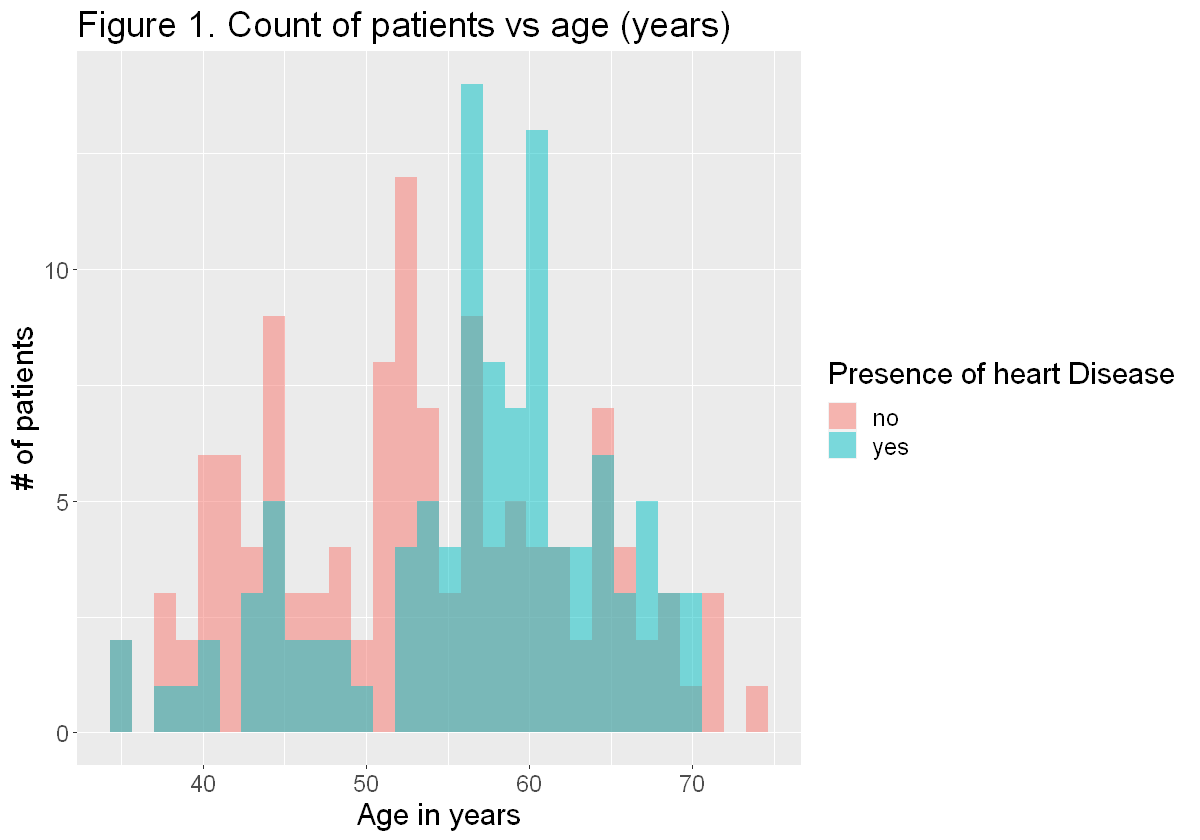

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



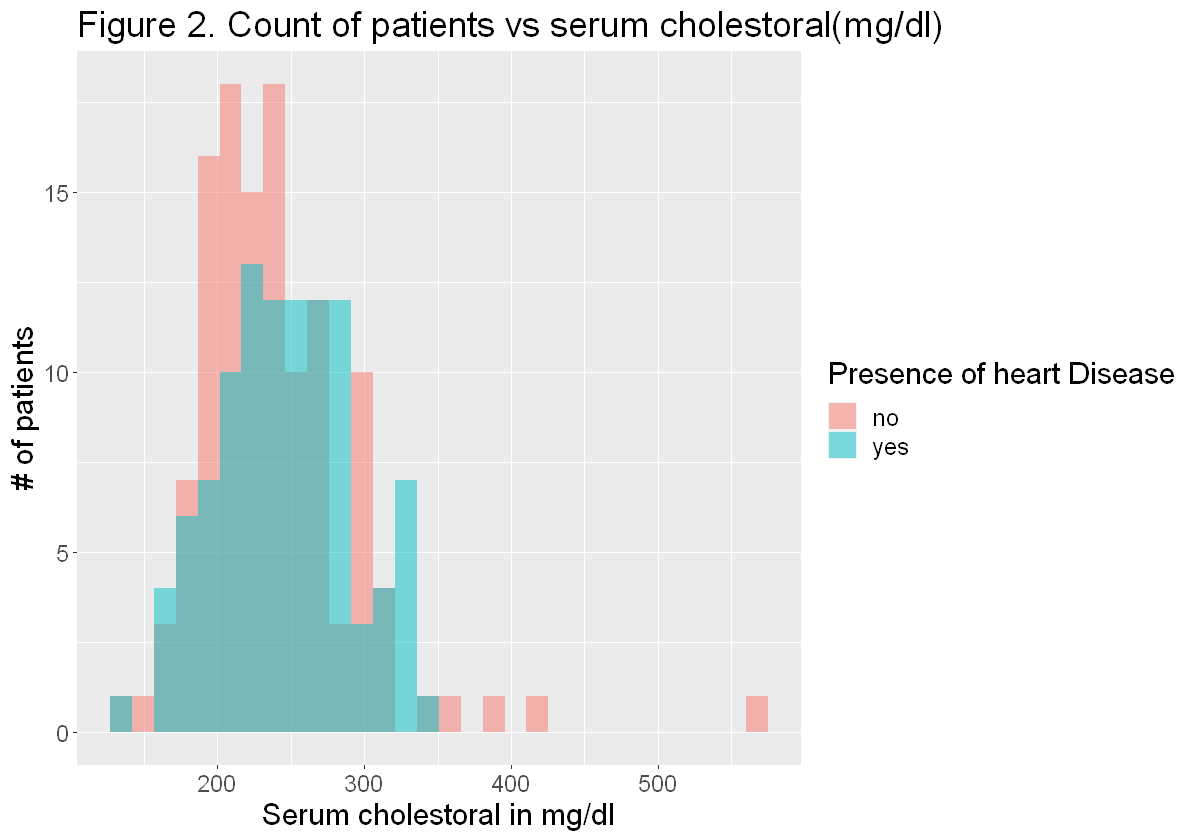

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



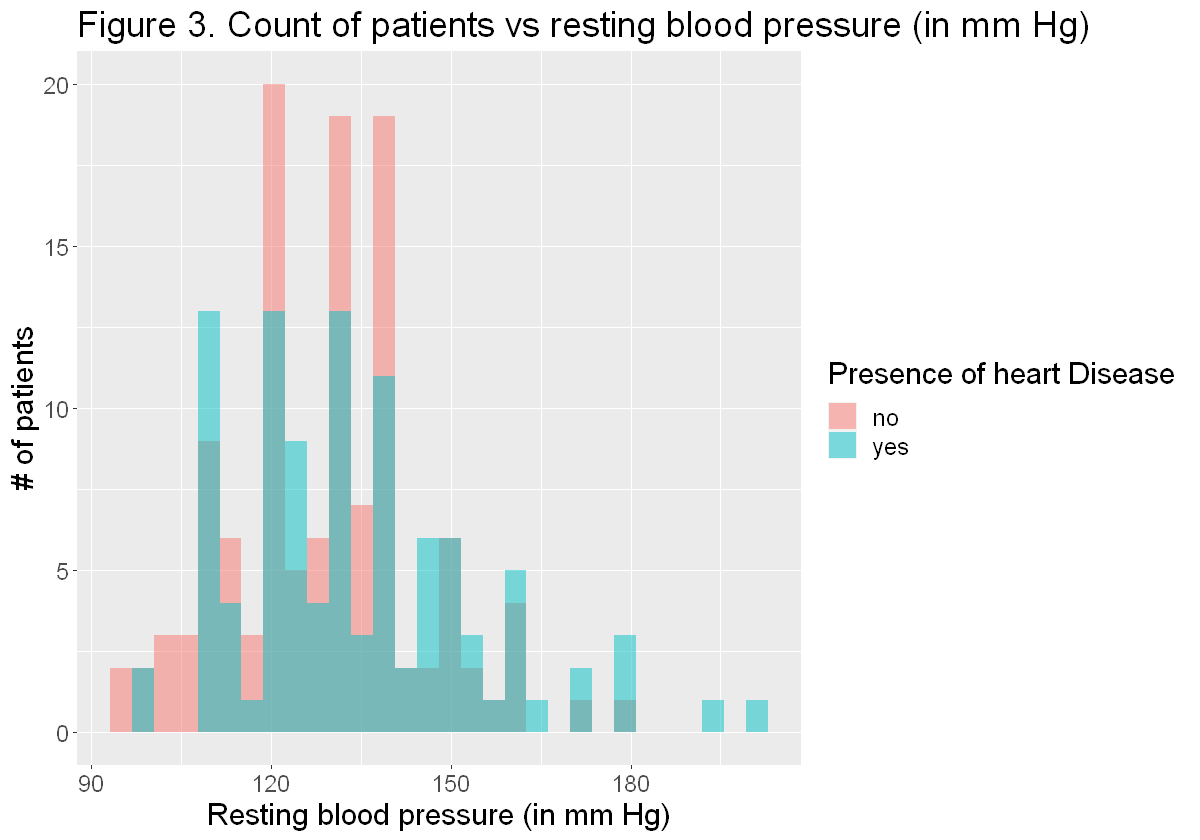

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



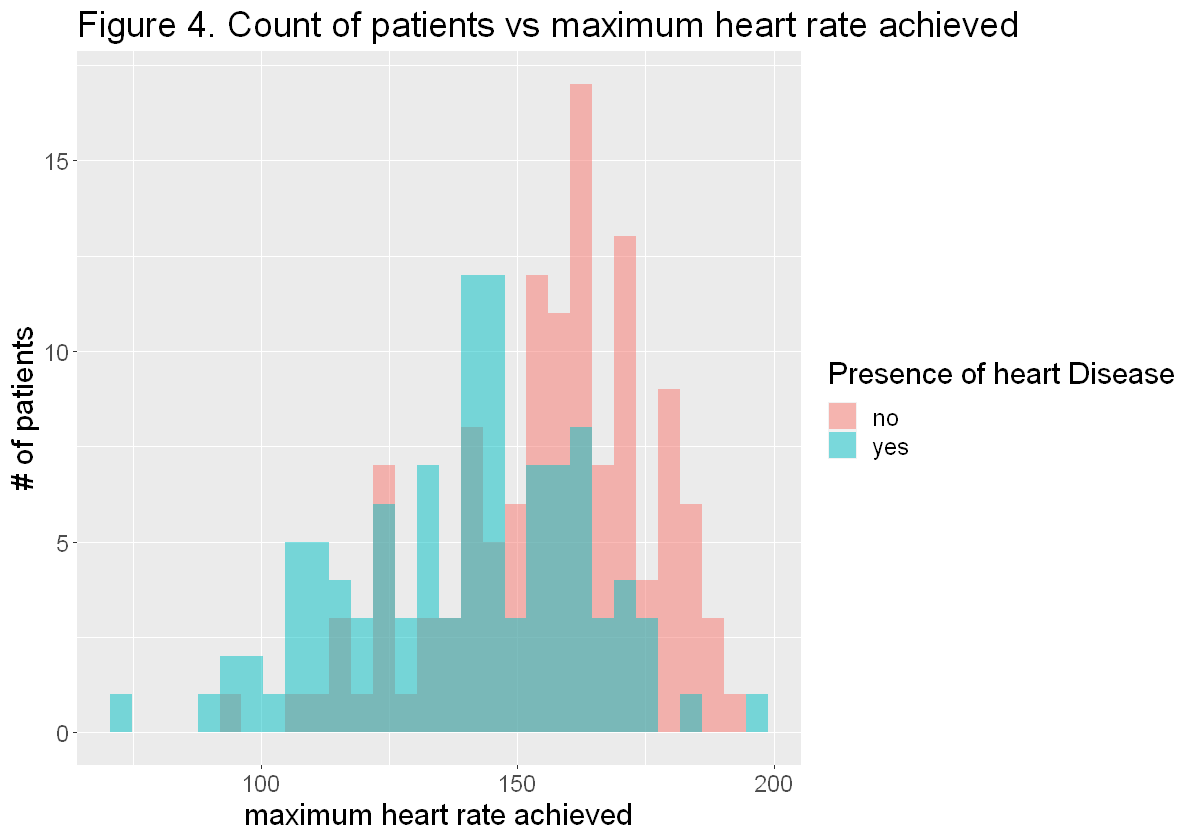

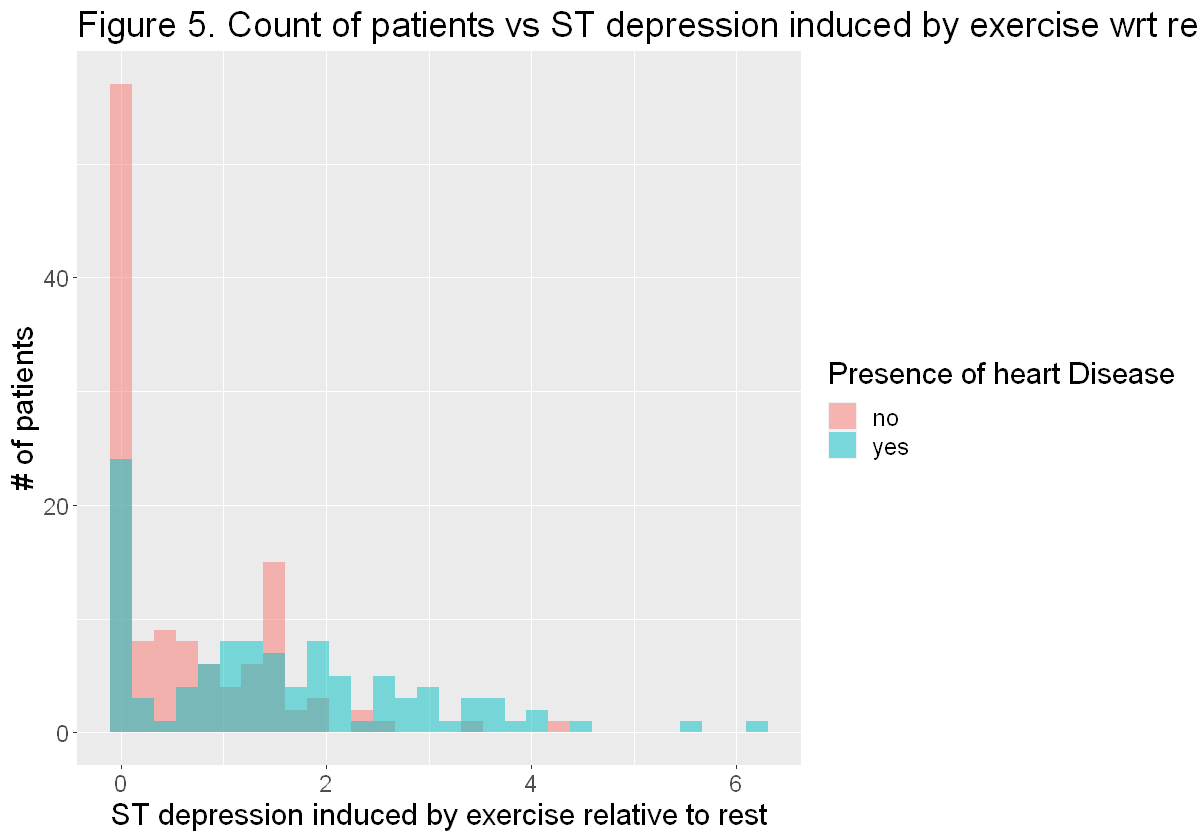

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Presence/absence based on age
heart_disease_data_train_age_plot <- ggplot(heart_disease_data_train, aes(x = age)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Age in years", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 1. Count of patients vs age (years)")
heart_disease_data_train_age_plot

# Presence/absence based on cholestrol
heart_disease_data_train_chol_plot <- ggplot(heart_disease_data_train, aes(x = chol)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Serum cholestoral in mg/dl", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 2. Count of patients vs serum cholestoral(mg/dl)")
heart_disease_data_train_chol_plot


# Presence/absence based on resting blood pressure
heart_disease_data_train_trestbps_plot <- ggplot(heart_disease_data_train, aes(x = trestbps)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Resting blood pressure (in mm Hg)", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 3. Count of patients vs resting blood pressure (in mm Hg)")
heart_disease_data_train_trestbps_plot

# Presence/absence based on maximum heart rate achieved
heart_disease_data_train_thalach_plot <- ggplot(heart_disease_data_train, aes(x = thalach)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "maximum heart rate achieved", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 4. Count of patients vs maximum heart rate achieved")
heart_disease_data_train_thalach_plot

# Presence/absence based on ST depression induced by exercise relative to rest
heart_disease_data_train_oldpeak_plot <- ggplot(heart_disease_data_train, aes(x = oldpeak)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "ST depression induced by exercise relative to rest", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 5. Count of patients vs ST depression induced by exercise wrt rest")
heart_disease_data_train_oldpeak_plot

### 2.5 Scatterplot of two variables at a time (EDA)

Here, will we do some exploratory data analysis, where for all the 5 variables - `age`, `chol`, `oldpeak`, `thalach`, `trestbps`, we will plot scatterplots for a combination of 2 variables at a time. Hence, we will plot 10 scatterplots in total.

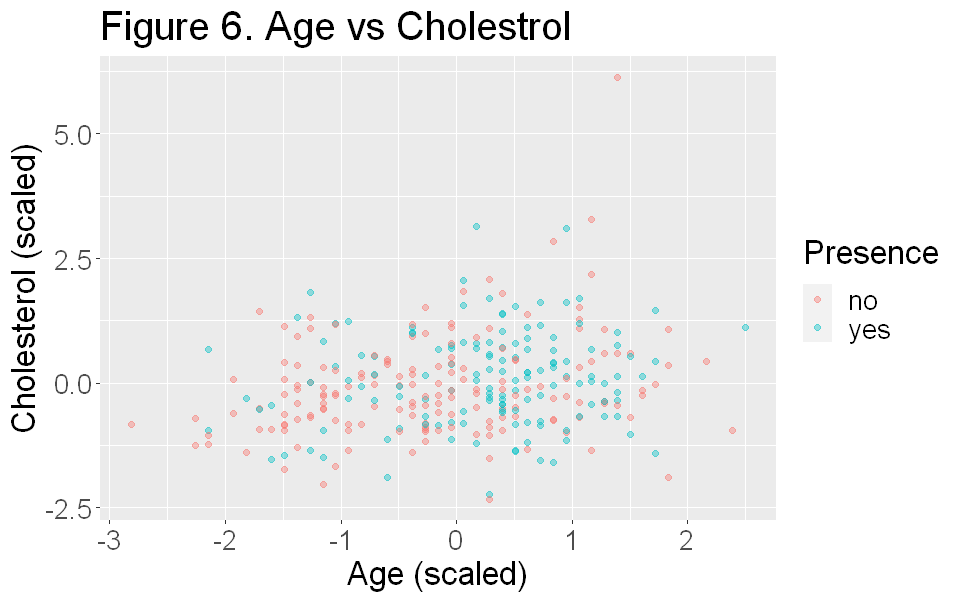

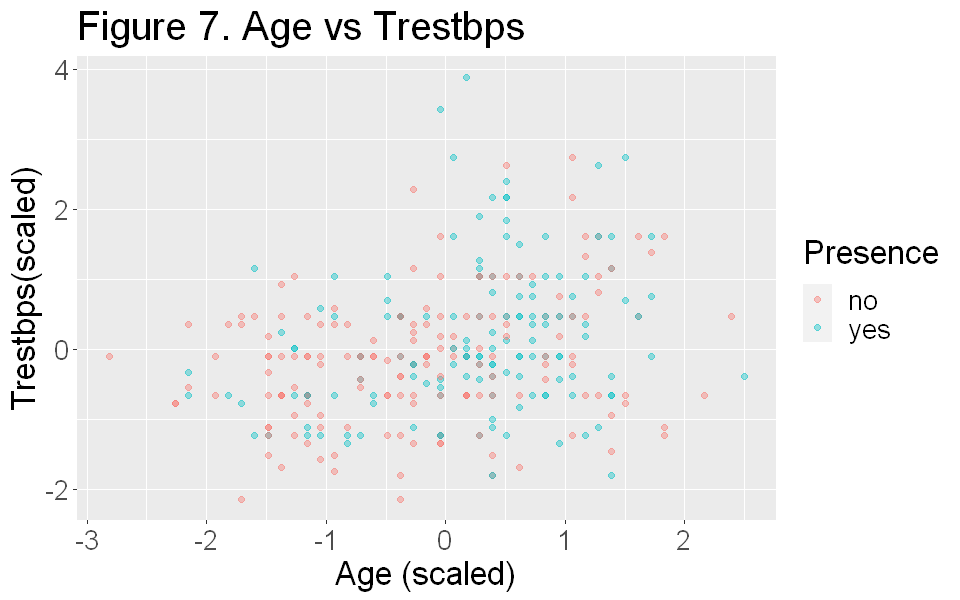

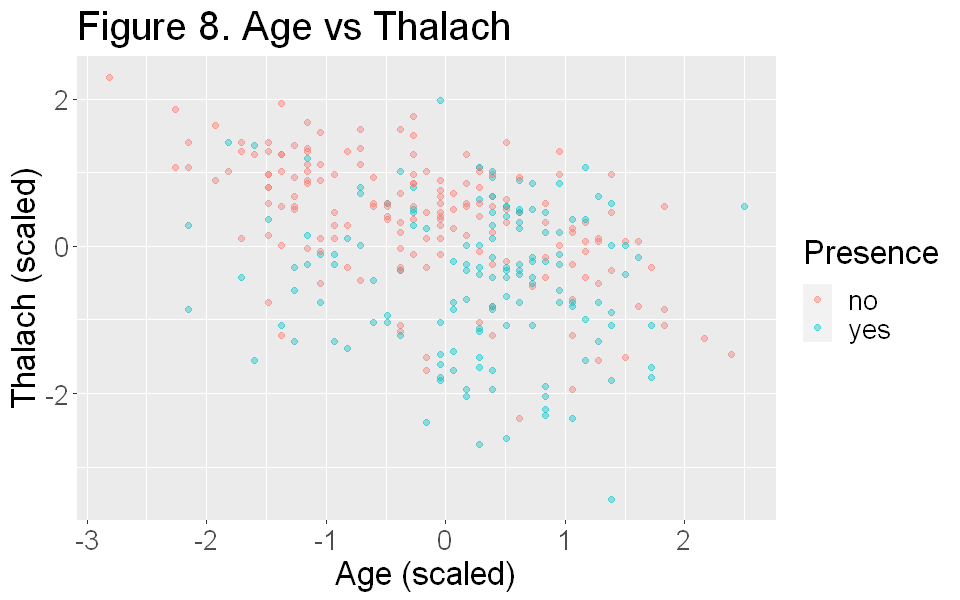

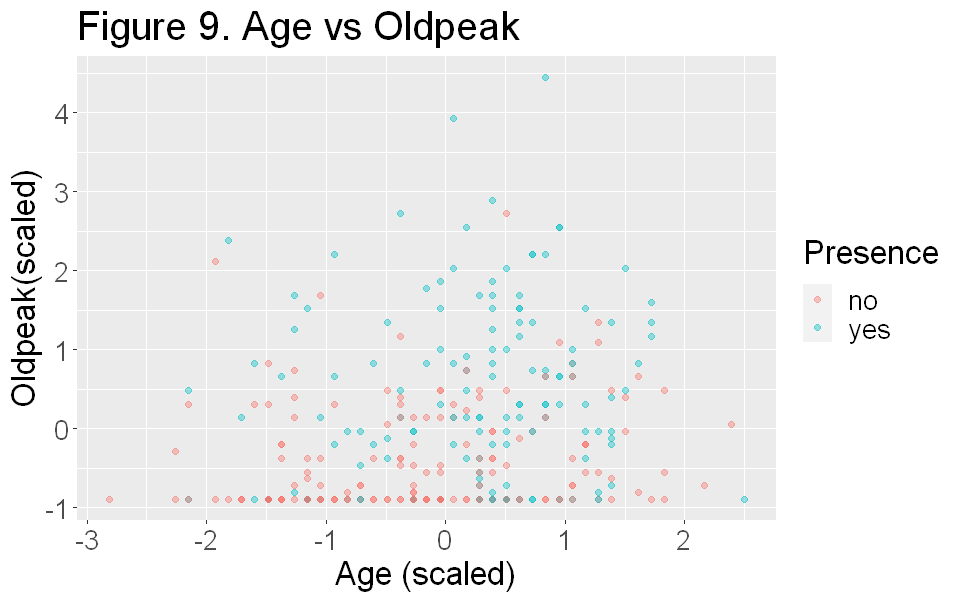

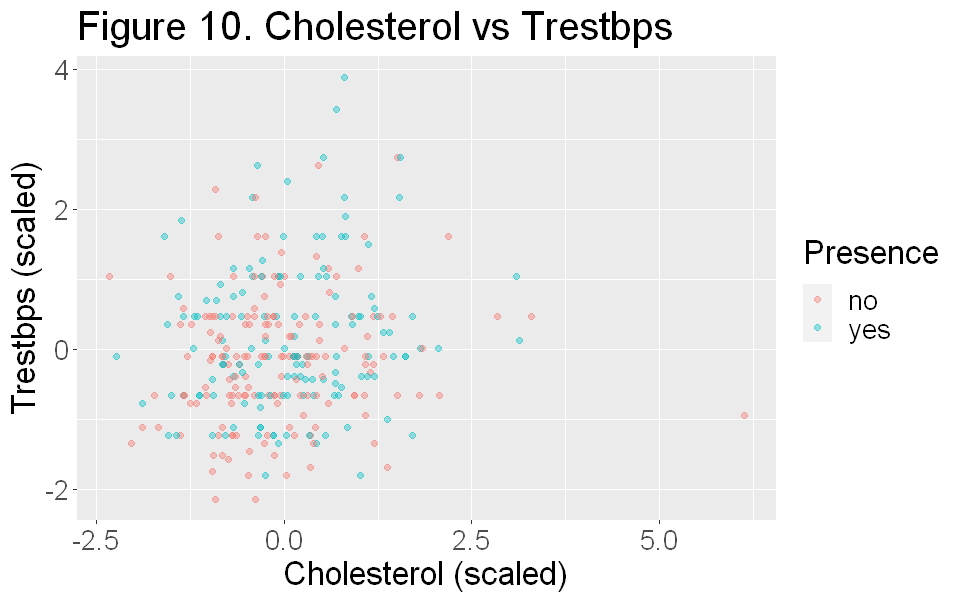

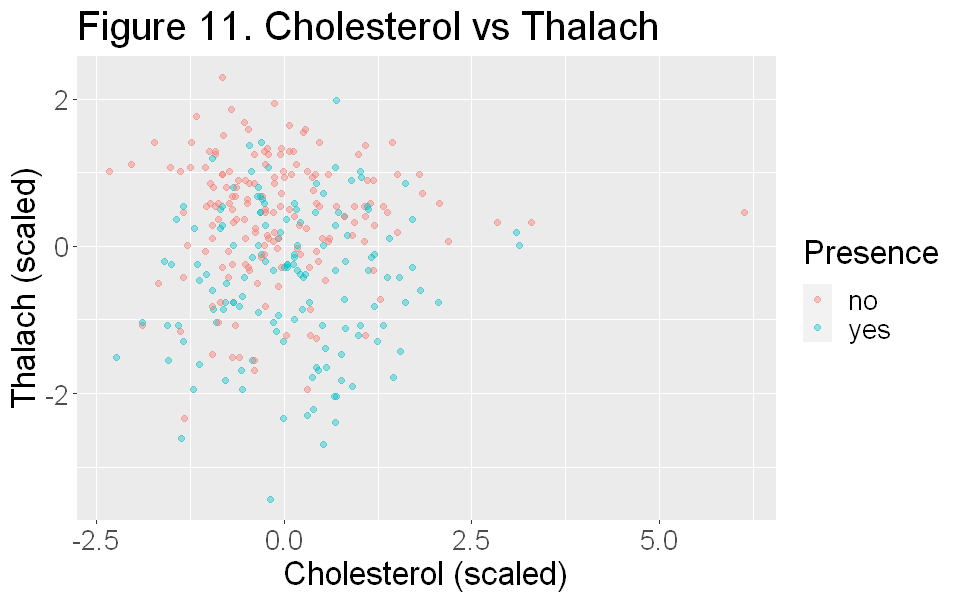

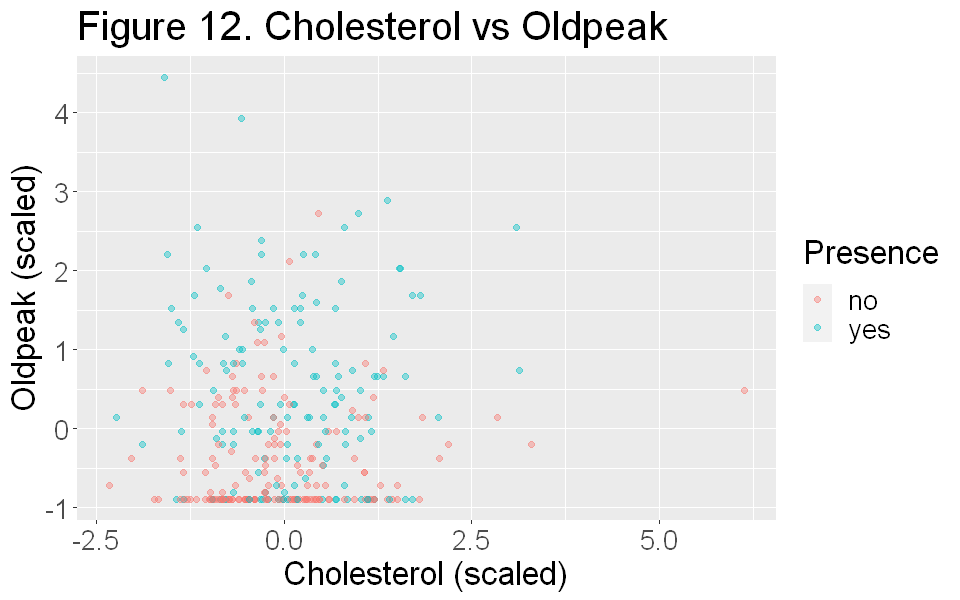

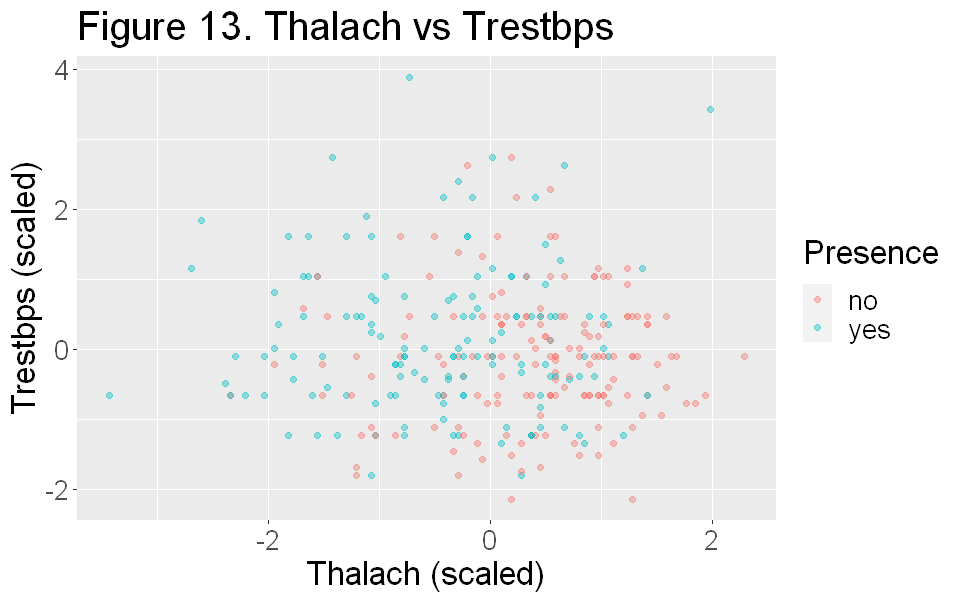

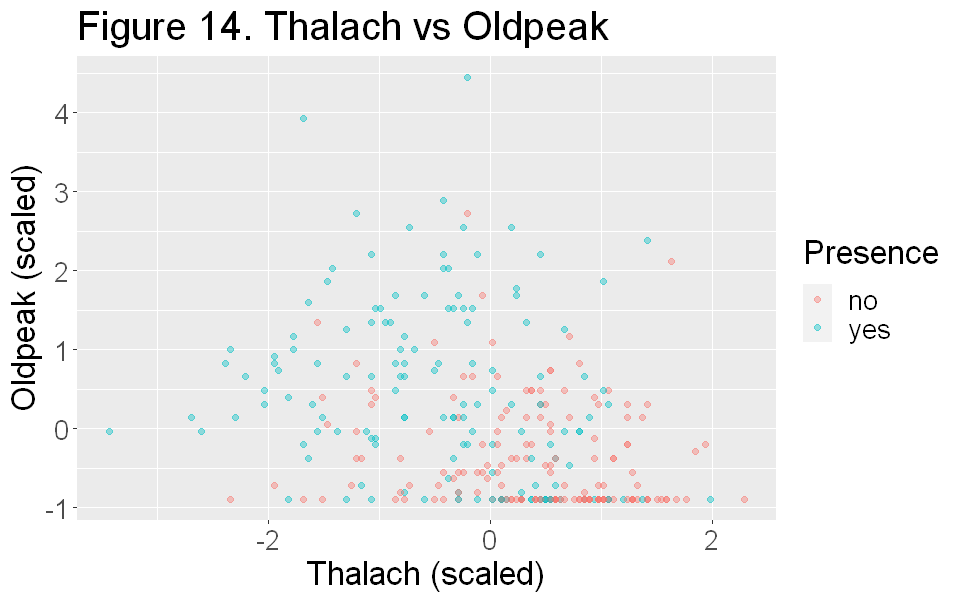

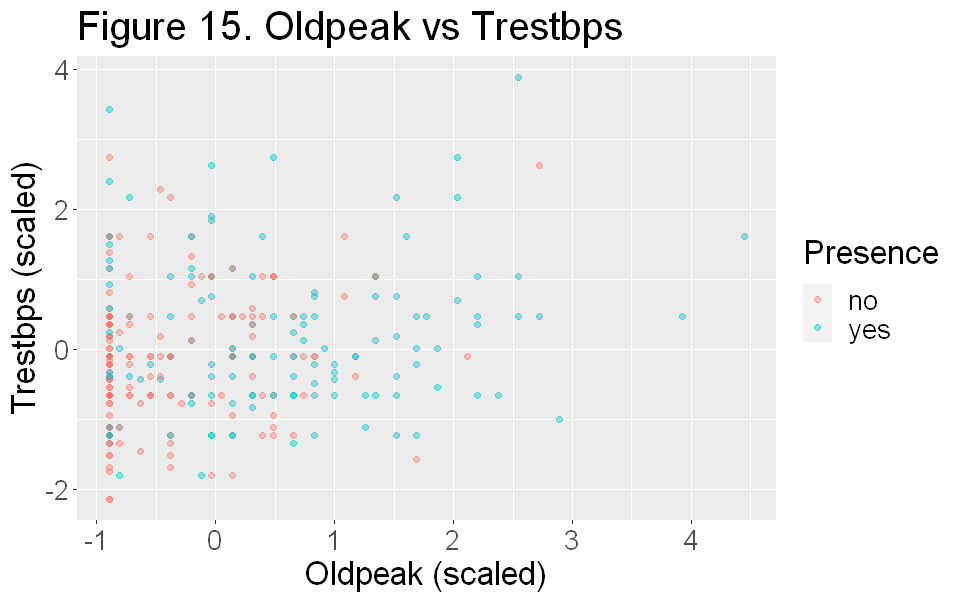

In [9]:
options(repr.plot.width = 8, repr.plot.height = 5)

# scale the variables 
heart_disease_data_scaled <- heart_disease_data %>%
  mutate(age = scale(age), chol = scale(chol), trestbps = scale(trestbps), thalach = scale(thalach), oldpeak = scale(oldpeak))

# 5 variables, 2 each time => 10 scatterplots 

# Age vs Chol
age_chol <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = chol, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Cholesterol (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 6. Age vs Cholestrol")
age_chol

# Age vs Trestbps
age_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Trestbps(scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 7. Age vs Trestbps")
age_trestbps

# Age vs Thalach
age_thalach <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = thalach, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Thalach (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 8. Age vs Thalach") 
age_thalach

# Age vs Oldpeak
age_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Oldpeak(scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 9. Age vs Oldpeak")
age_oldpeak

# Chol vs Trestbps
chol_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 10. Cholesterol vs Trestbps")
chol_trestbps

# Chol vs Thalach
chol_thalach <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = thalach, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Thalach (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 11. Cholesterol vs Thalach")
chol_thalach

# Chol vs Oldpeak
chol_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Oldpeak (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 12. Cholesterol vs Oldpeak")
chol_oldpeak

# Thalach vs Trestbps
thalach_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = thalach, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Thalach (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 13. Thalach vs Trestbps")
thalach_trestbps

# Thalach vs Oldpeak
thalach_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = thalach, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Thalach (scaled)", 
       y = "Oldpeak (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 14. Thalach vs Oldpeak")
thalach_oldpeak

# Oldpeak vs Trestbps
oldpeak_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = oldpeak, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Oldpeak (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 15. Oldpeak vs Trestbps")
oldpeak_trestbps


We can see that `Age` vs `Thalach`, `Age` vs `Oldpeak`, `Oldpeak` vs `Thalach` are still the best variables that can successfully distinguish between presence and absence of heart disease without getting stacked (overlapped) on top of each other, thus helping in effective classificiation.

### 2.6 EDA (using ggpairs) 

We will examine the relationships between our 5 predictor attributes - `age`, `chol`, `oldpeak`, `thalach`, `trestbps` and the predicted attribute `presence` to select the most relevant attributes for our classification model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



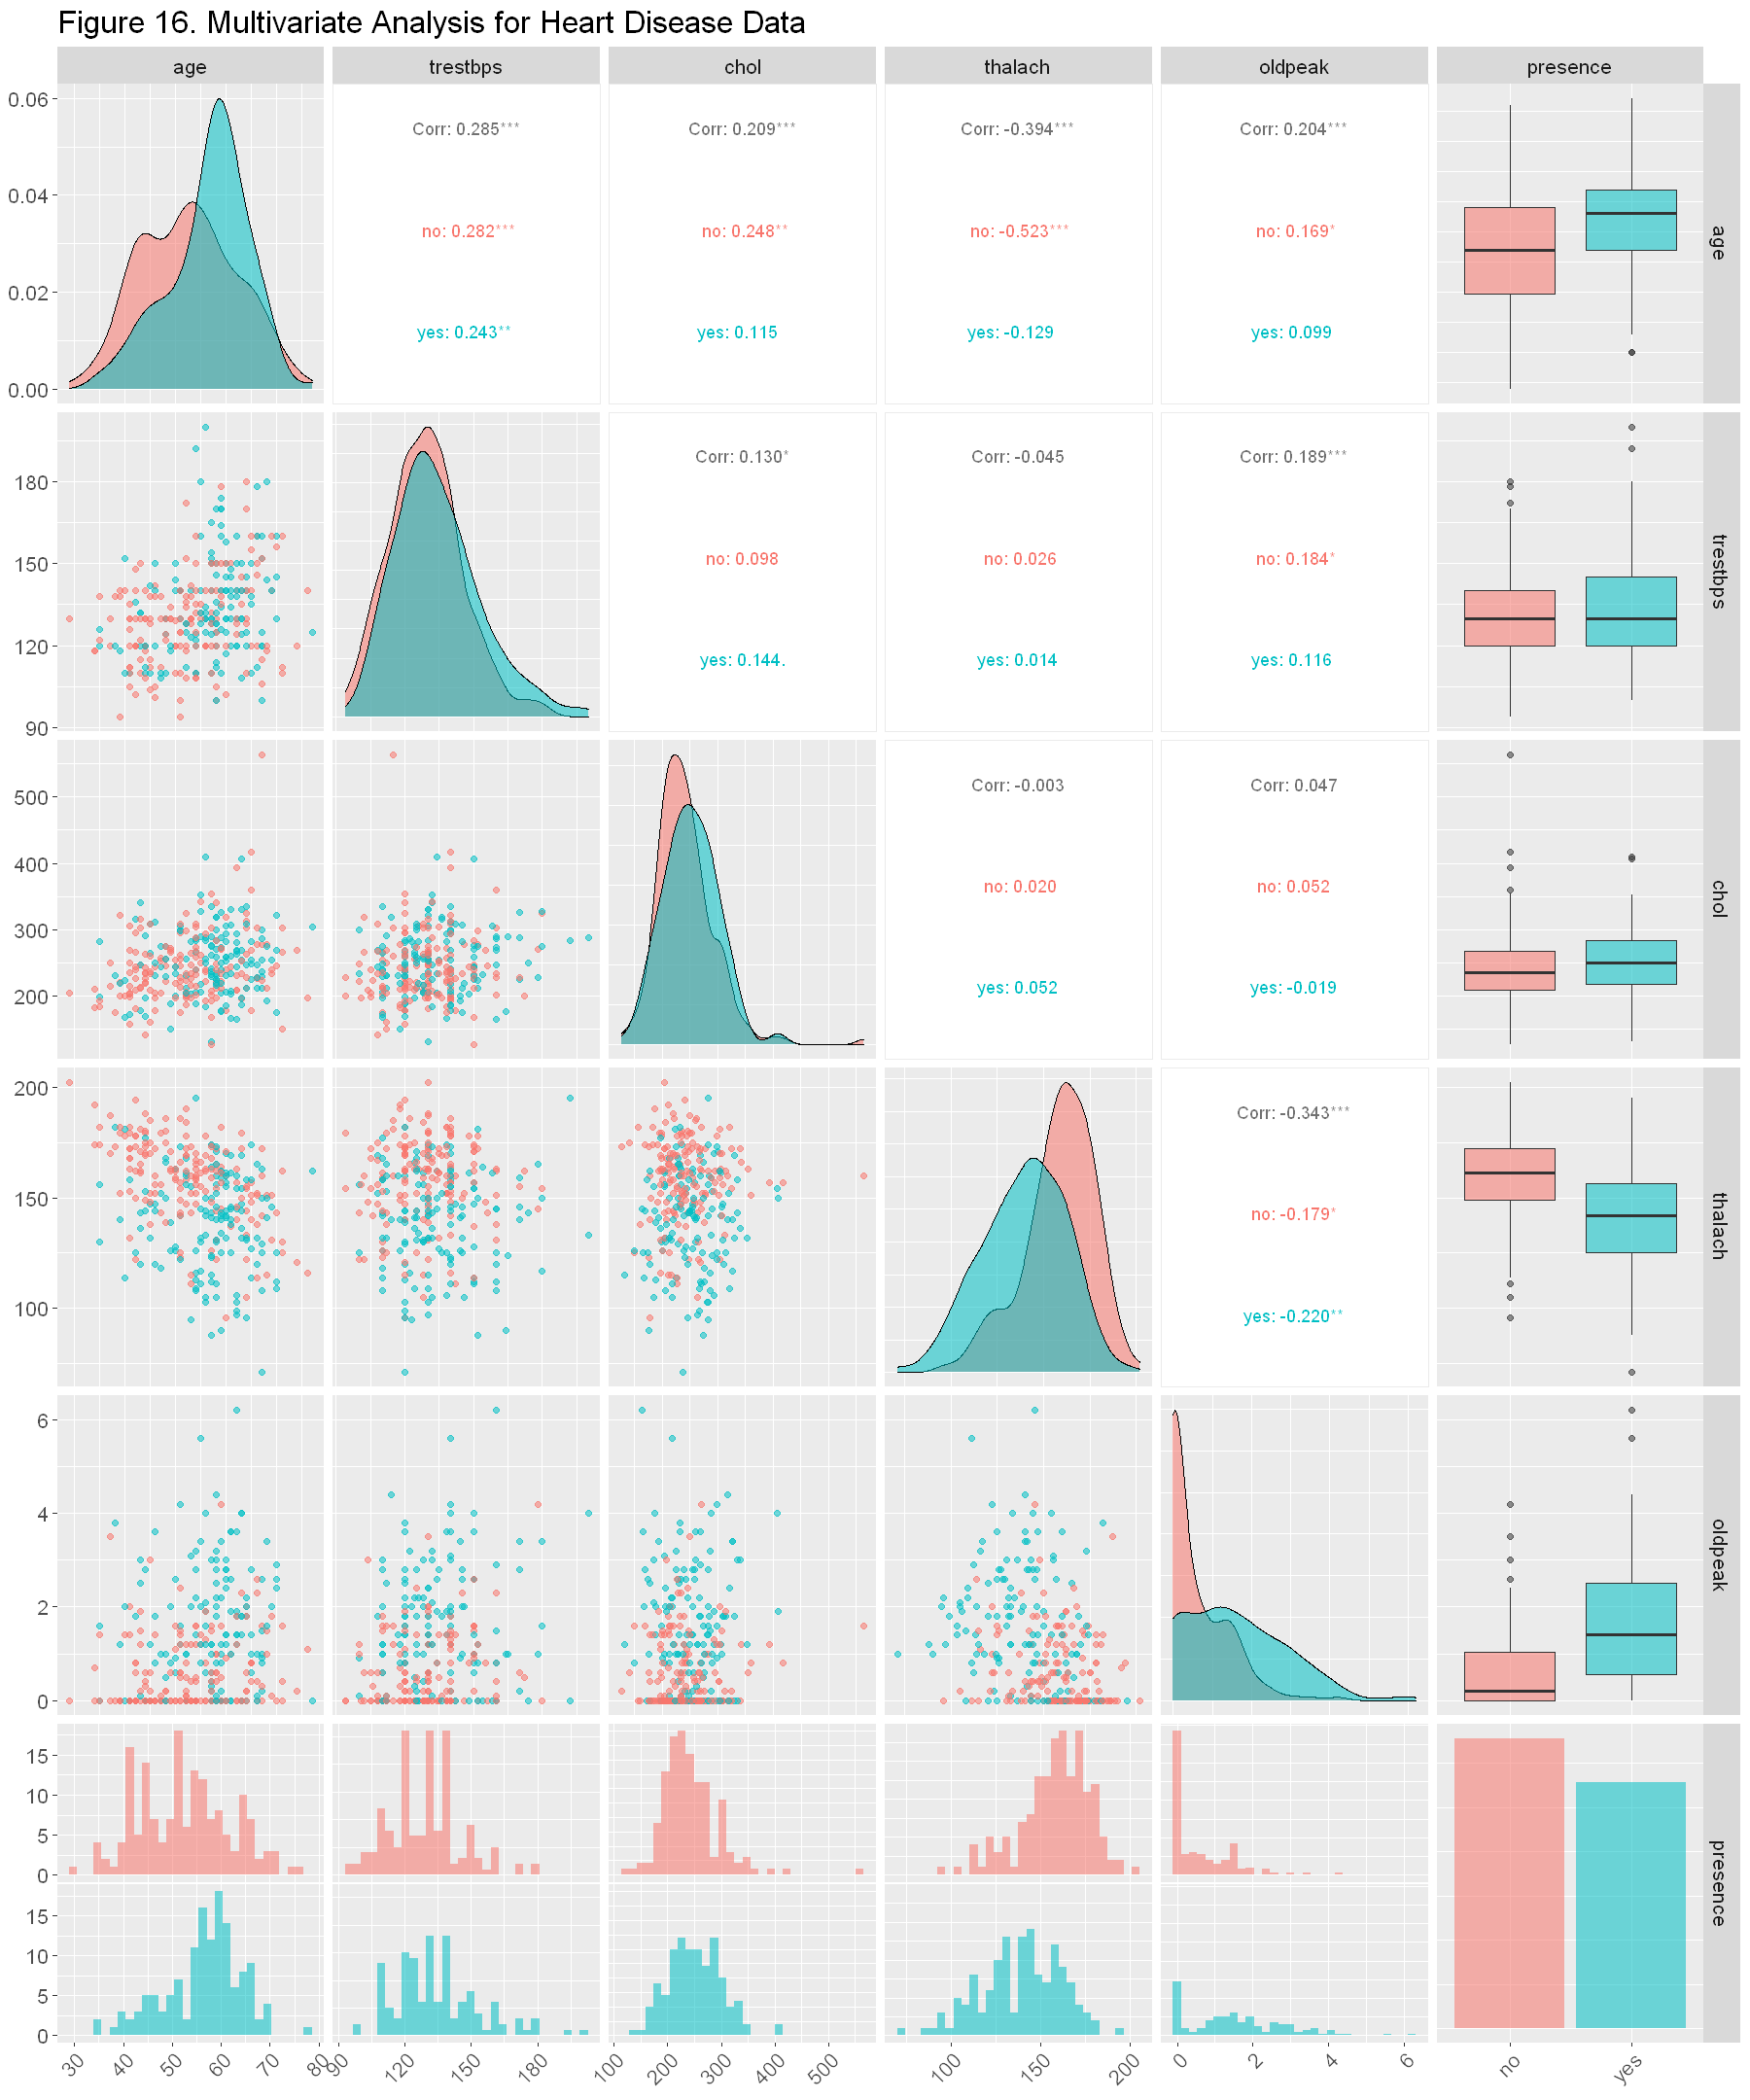

In [10]:
options(repr.plot.width = 15, repr.plot.height = 18)

#scatterplot matrix (ggpairs) with all categorical variables
multivariate_plot <- heart_disease_data %>%
    ggpairs(mapping = ggplot2::aes(colour = presence, alpha = 0.4)) +  
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 16. Multivariate Analysis for Heart Disease Data")

multivariate_plot 

From the plot above we can see that `age`, `thalach`, and `oldpeak` are the best three attributes which do not have overlapping plots and can help distinguish between the presence and absense of heart disease in a patient and can therefore be use effectively in training our classificiation model.

## 3. Classification

Many physiological attributes have been shown through studies and reports by the CDC and WHO to have strong links to heart disease. After filtering out categorical variables and examining the data using `ggpairs`, we have chosen the three most relevant out of the five numerical values in our dataset to analyze: `thalach` (maximum heart rate achieved), `oldpeak` (ST depression induced by exercise relative to rest), and `age` (age in years). Using ggpairs, we can see that `oldpeak`, `thalach`, and `age` work better in helping distinguish the classification between the presence and absense of heart disease as their plots do not completely overlap. Using our chosen variables, we will construct and test a classifier using the KNN classification model and choose an appropriate k using cross-validation.

### 3.1 Creating the model and recipe

In [11]:
#Creating model and recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")


hd_recipe <- recipe(presence ~ age + oldpeak + thalach, data = heart_disease_data_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

hd_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### 3.2 Performing cross-validation and determining which k to use

Finding the best K for KNN by varying K from 1 to 125 in increments of 2 and running a 5-fold cross validation. We will then filter the maximum accuracy neighbour and see if it is the right K to choose using the plot below.

In [12]:
set.seed(999)
hd_vfold <- vfold_cv(heart_disease_data_train, v = 5, strata = presence)

k_vals <- tibble(neighbors = seq(from = 1, to = 125, by = 2))

# workflow 
knn_results <- workflow() %>%
                 add_recipe(hd_recipe) %>%
                 add_model(knn_spec) %>%
                 tune_grid(resamples = hd_vfold, grid = k_vals) %>%
                 collect_metrics()

## accuracies for all the neighbours of k =1 to k = 125 in increments of 2
accuracies <- knn_results %>%
                 filter(.metric == "accuracy")
accuracies

## maximum accuracy 
max_accuracy <- accuracies %>%
                    filter(mean == max(mean))
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6558630,5,0.04793530,Preprocessor1_Model01
3,accuracy,binary,0.6333377,5,0.04309644,Preprocessor1_Model02
5,accuracy,binary,0.6331401,5,0.04483357,Preprocessor1_Model03
7,accuracy,binary,0.6599166,5,0.03090470,Preprocessor1_Model04
9,accuracy,binary,0.6555687,5,0.02913862,Preprocessor1_Model05
11,accuracy,binary,0.6910321,5,0.03422865,Preprocessor1_Model06
13,accuracy,binary,0.7037857,5,0.03877001,Preprocessor1_Model07
15,accuracy,binary,0.7126746,5,0.03770146,Preprocessor1_Model08
17,accuracy,binary,0.6996355,5,0.03118728,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
59,accuracy,binary,0.7219631,5,0.03169323,Preprocessor1_Model30


### 3.3 Plot of K vs Accuracy to choose the most optimal K value 

As we can see from above we get the maximum accuracy at k = 59. We will examine the plot below to determine the most optimal K.

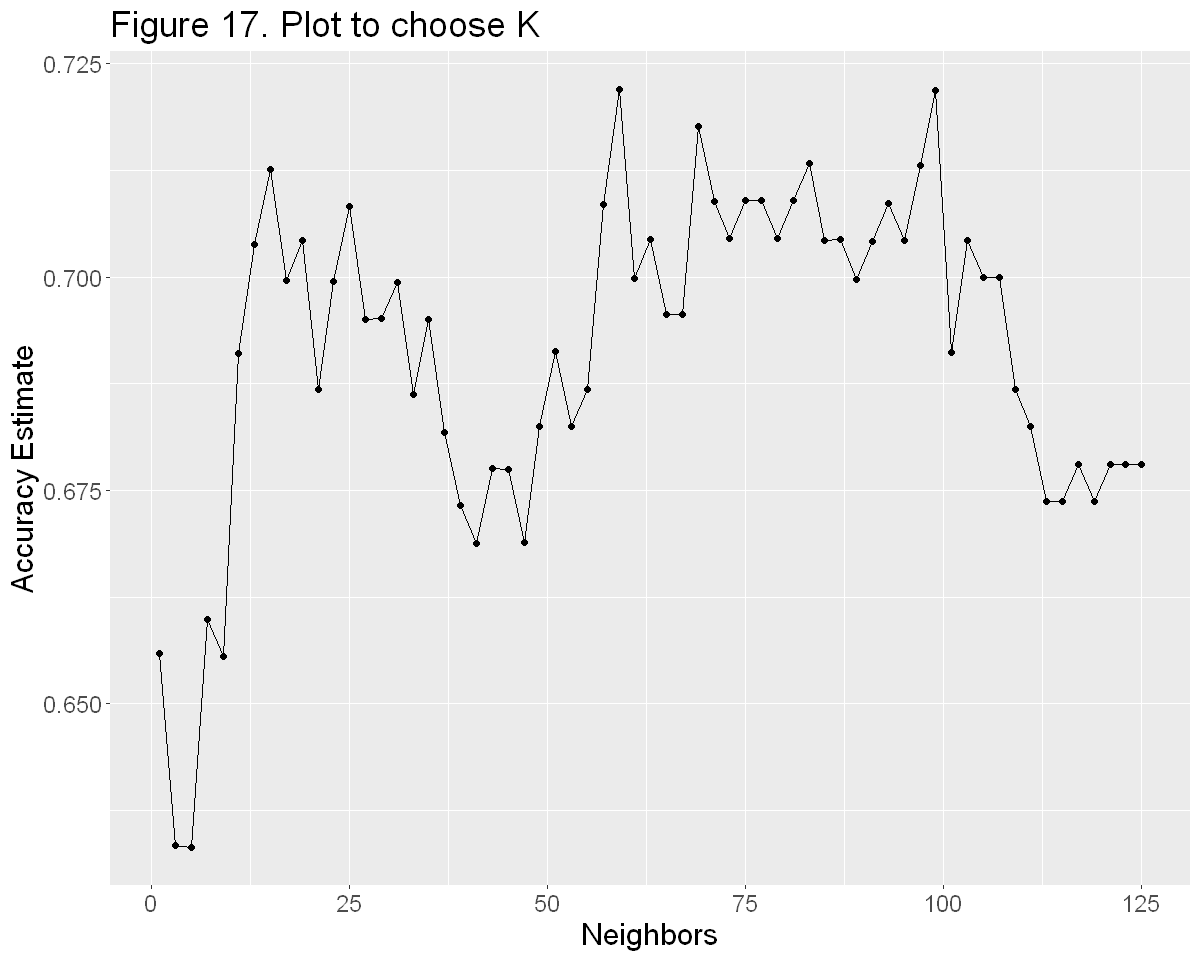

In [13]:
options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 18)) +
                  ggtitle("Figure 17. Plot to choose K")
cross_val_plot

From the plot above, we see that the plot seems to oscillate a lot as the number of neighbors increases. This is likely because the dataset is small (only ~300 rows of data) which is why the model is trying to gather as much information possible by having more neighbors. However we notice that k = 59 is the optimal choice of K since it gives us the maximum accuracy and is also a reasonably right number of neighbors to avoid underfitting or overfitting. Cost of training will not be very expensive either since k is not too large but optimal.

In [14]:
# spec with num of neighbors = 59
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 59) %>%
  set_engine("kknn") %>%
  set_mode("classification")

hd_fit <- workflow () %>%
                  add_recipe(hd_recipe) %>%
                  add_model(knn_spec2) %>% 
                  fit(data = heart_disease_data_train)
hd_fit

== Workflow [trained] ==========================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model -----------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(59,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3215859
Best kernel: rectangular
Best k: 59

In [15]:
hd_test_predictions <- predict(hd_fit, heart_disease_data_test) %>%
  bind_cols(heart_disease_data_test)

hd_metrics <- hd_test_predictions %>% 
                metrics(truth = presence, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

hd_conf_mat <- hd_test_predictions %>%
                        conf_mat(truth = presence, estimate = .pred_class) 

hd_metrics
hd_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


          Truth
Prediction no yes
       no  36  14
       yes  5  21

From our metrics and confusion matrix above, we can see that our model is about 75% accurate. Of the 76 observations in our test data, 57 (36 + 21) of them are correctly classified. 19 of them were either false positives (27.8%) or false negatives (77.8%). 

### 3.4 Comparing presence to predicted presence 

In the following graphs, we look at the actual presence values on the left plots, and the predicted presence values (from our model) on the right plots. These are scatterplots between two attributes at a time from the three attributes - `age`, `thalach`, `oldpeak` - that we used in our classification model. 

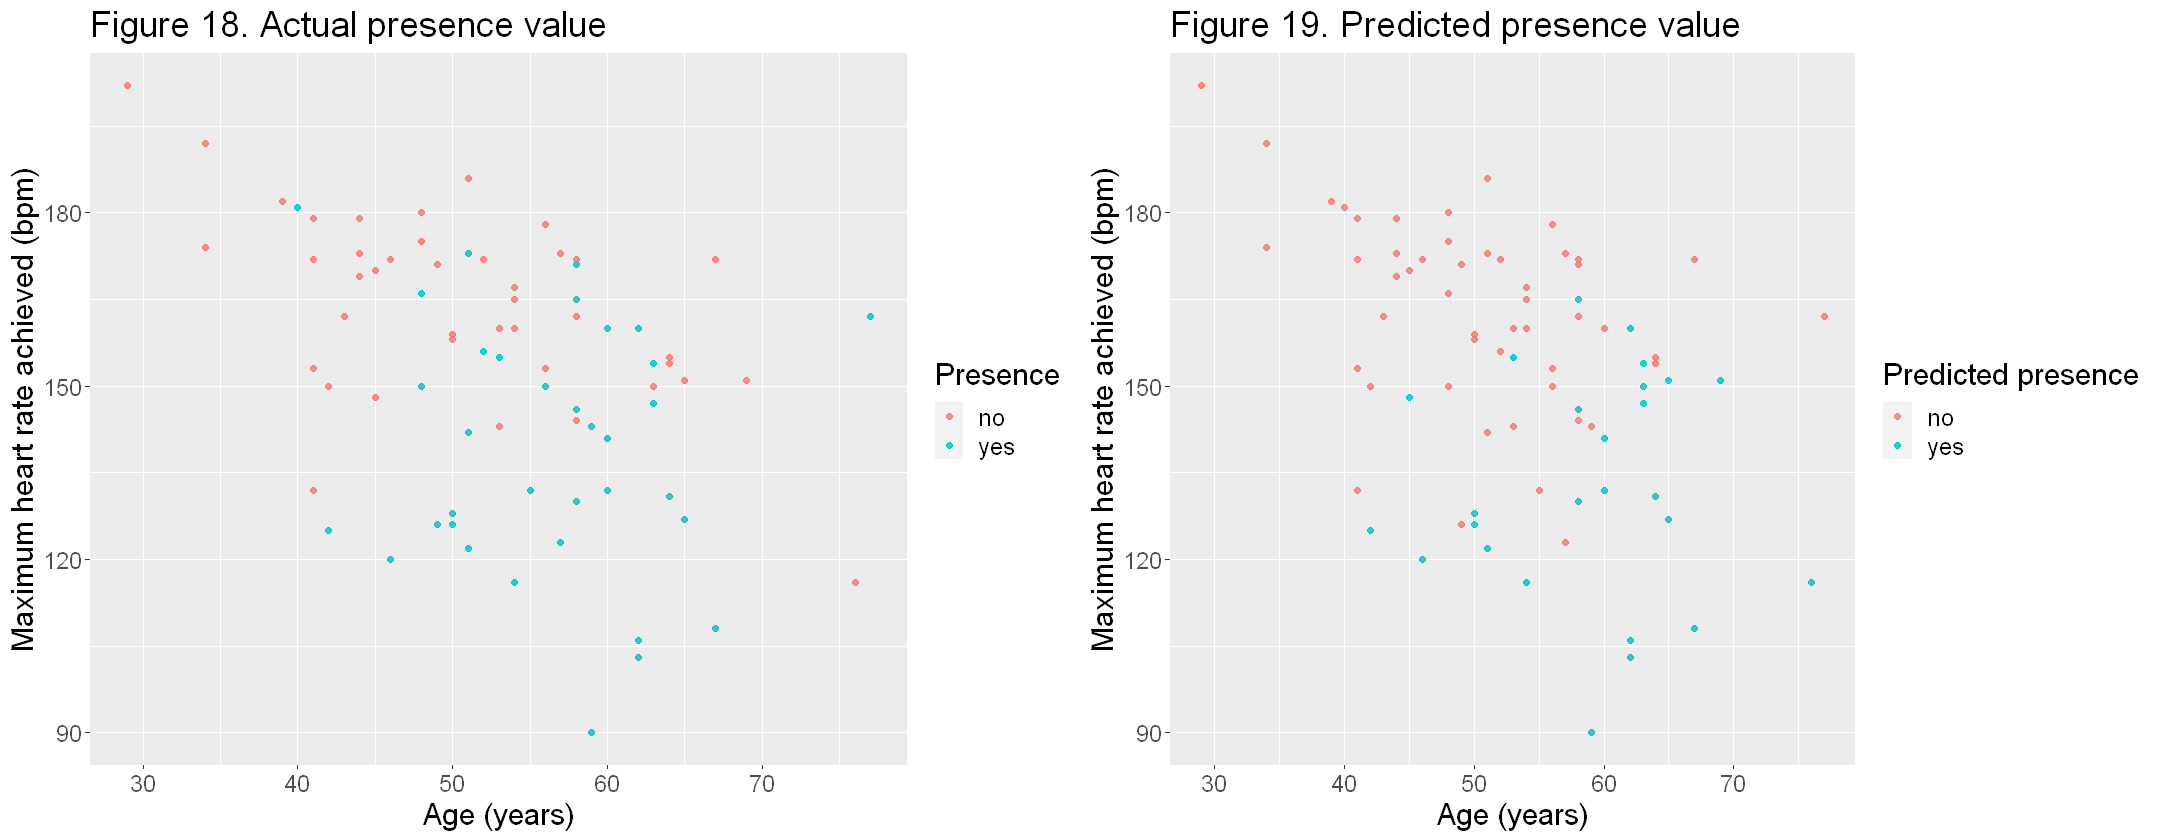

In [16]:
library(cowplot)
options(repr.plot.width = 18, repr.plot.height = 7)

age_thalach_plot <- ggplot(hd_test_predictions, aes(x = age, y = thalach, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "Maximum heart rate achieved (bpm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 18. Actual presence value")


age_thalach_preds <- ggplot(hd_test_predictions, aes(x = age, y = thalach, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "Maximum heart rate achieved (bpm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 19. Predicted presence value")

plot_grid(age_thalach_plot, age_thalach_preds)

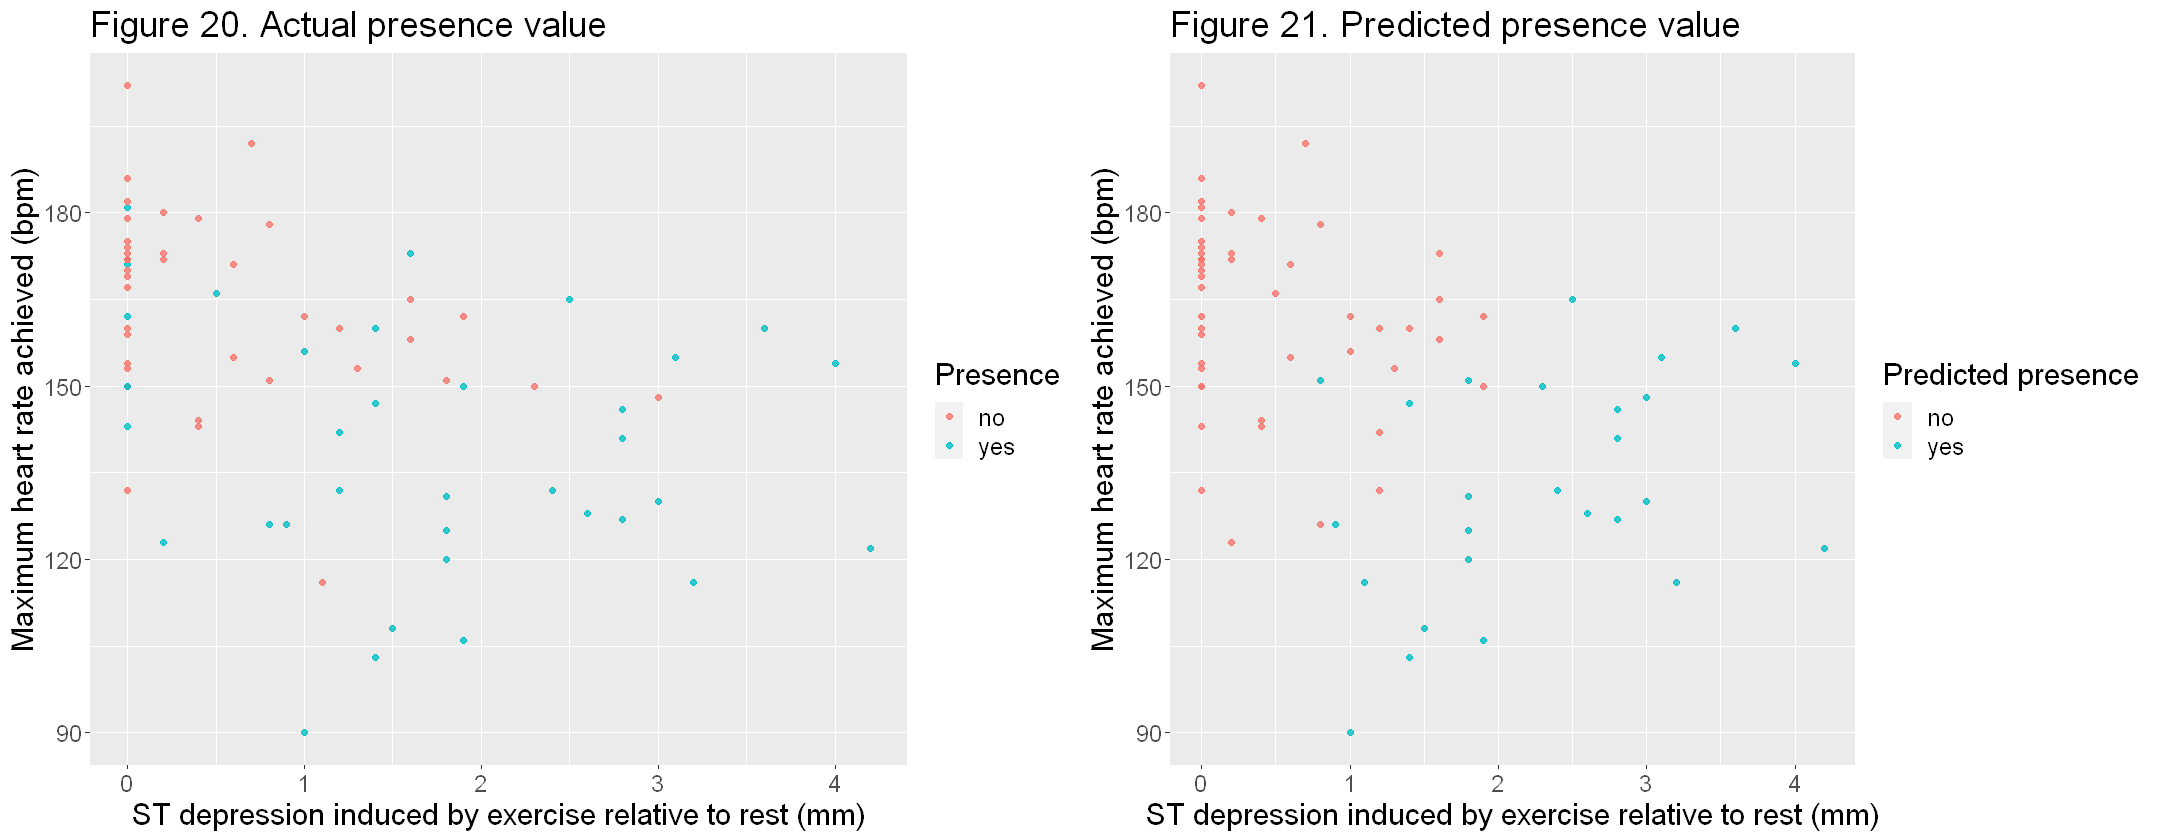

In [17]:
options(repr.plot.width = 18, repr.plot.height = 7)

oldpeak_thalach_plot <- ggplot(hd_test_predictions, aes(x = oldpeak, y = thalach, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Maximum heart rate achieved (bpm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 20. Actual presence value")

oldpeak_thalach_preds <- ggplot(hd_test_predictions, aes(x = oldpeak, y = thalach, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Maximum heart rate achieved (bpm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 21. Predicted presence value")
plot_grid(oldpeak_thalach_plot, oldpeak_thalach_preds)

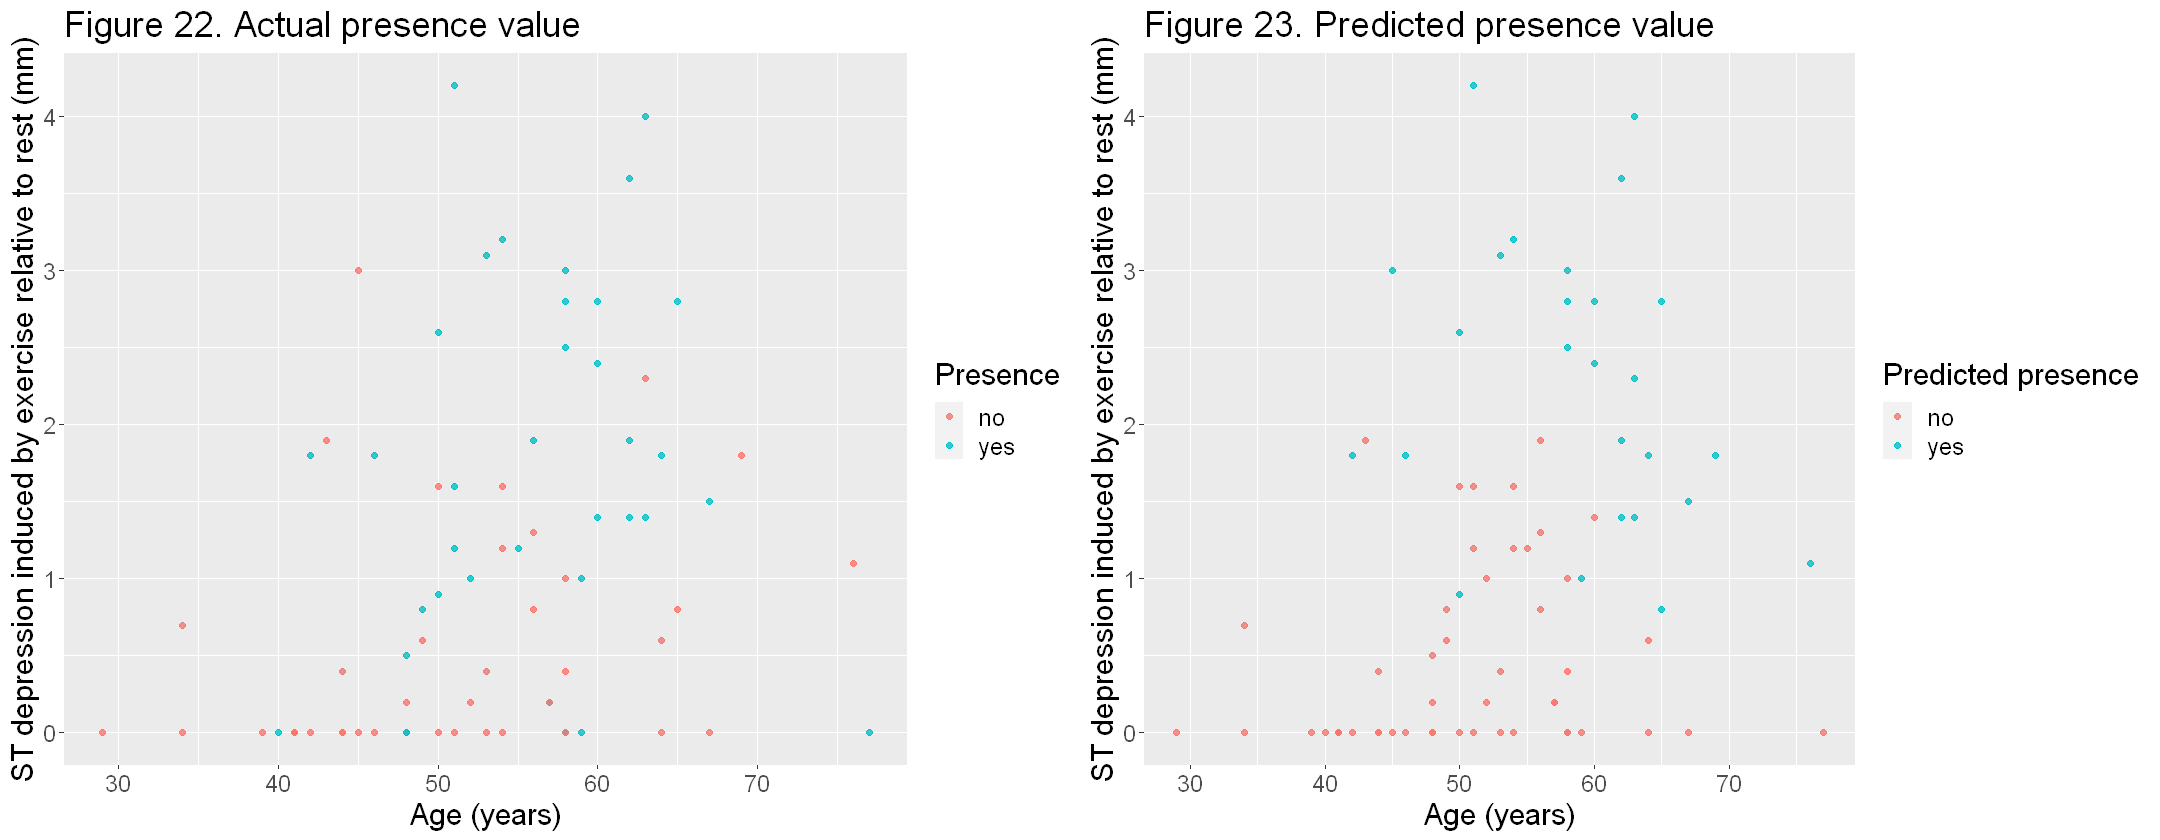

In [18]:

options(repr.plot.width = 18, repr.plot.height = 7)

age_oldpeak_plot <- ggplot(hd_test_predictions, aes(x = age, y = oldpeak, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "ST depression induced by exercise relative to rest (mm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 22. Actual presence value")

age_oldpeak_preds <- ggplot(hd_test_predictions, aes(x = age, y = oldpeak, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "ST depression induced by exercise relative to rest (mm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 23. Predicted presence value")

plot_grid(age_oldpeak_plot, age_oldpeak_preds)

## 4. Discussion

### 4.1 Findings
Our pre-analysis of variables showed the most accurate predictors were age, maximum heart rate achieved during exercise, and ST depression induced by exercise. This is corroborated by studies in the European Heart Journal, which concluded that ST segment depression is associated not only with a 100% increase in the occurrence of three-vessel/left main disease but also with an increased risk of subsequent cardiac events, and an analysis published in the Circulation Research journal which analyzed various studies linking the molecular biology of aging and cardiovascular health.

Using this information, we built a classification model with three predictors (age, thalach, oldpeak) and determined on testing data that it can predict with about 75% accuracy whether heart disease will be present or absent in a new, unseen patient.

As seen in our side-by-side plots comparing presence and predicted presence (Figures 18-23), we can see that our classifier model groups each patient into two noticeable clusters on each predicted presence graph. However, our model wrongly classifies points that appear to be outliers, as the clusters in the actual presence value graphs are not highly separated and distinct. If we were to visualize the points on a 3D plane rather than only plot two variables at a time, then we may be able to collect more information on which points are outliers and if there are any additional trends among those groups. In addition, this model only looks for presence of having heart disease, while the dataset also includes the type of the heart disease of the patient. These differences in the classification of the heart disease itself may help explain the outliers, and point to clusters not detected in this model (which can affect the accuracy for each disease presence).

Aside from the comparisons between our predicted presence values and actual presence values, we noticed a weak negative relationship between age and maximum heart rate achieved during exercise. No other notable relationships were observed between the other variables we used in our model. We are unable to draw significant conclusions without more information on how the study was conducted and how data was collected. 


### 4.2 Expectations 
Originally, we expected other numeric variables such as chol and trestbps to be relevant in building our classification model due to prior associations between these variables and heart disease. Our pre-analysis and graphs evidently suggested otherwise. Upon further investigation, we realized the variables may not reflect what we assumed they did. For instance, while there are studies linking cholesterol to heart disease, cholesterol increases risk by building up deposits in blood vessels. This buildup takes time, so one measurement may not be indicative of a patient's health. Similarly, due to the variation in blood pressure throughout the day (data was collected on admission to the hospital which differs between patients), `trestbps` is not as meaningful of a measurement here despite high blood pressure being linked with heart disease. `thalach` and `oldpeak`, by comparison, were collected when patients were under the conditions of an exercise test.

We also had expected to be able to develop a higher accuracy model overall for our intended purposes. Our model was built to classify the presence or absence of heart disease in a patient. For such a domain, we would like to have very high accuracy to avoid false negatives where someone is classified as being absent of heart disease but may actually be at risk and require treatment. In order to achieve higher accuracy, we may need to investigate other numeric variables included in other datasets, or use other classification methods not covered in DSCI 100. Despite previous scientific knowledge of the relationships between the variables included in the data set, the relatively low accuracy for our model tells us about the highly variable nature of biology and cardiovascular health between people.

### 4.3 Possible Impacts
- Using our model, patients can be classified as high or low risk for heart disease using their age (`age`), maximum heart rate achieved (`thalach`), and ST depression induced by exercise wrt rest (`oldpeak`). However, the model is not accurate to the standards of a professional medical diagnosis tool. Patients who are classified as "yes" for presence of heart disease are recommended to look into the possibility with a licensed doctor, but those who are classified as "no" should not rule out the possibility and should seek professional advice if symptoms are observed. 
- The model can serve as a framework for a more accurate model using other methods or variables that can reduce our rate of false negatives. 
- More investigation into the results of our data and preexisting scientific knowledge can tell us more about how data collection impacts the results of subsequent analysis. For instance, the previously studied links between blood cholesterol/blood pressure and heart disease were not reflected in our analysis, possibly due to differences in data collection (blood pressure) or the nature of how the variable is known to impact heart disease (cholesterol). 
- Early investigation into and diagnosis of heart disease based on this classification can help save more lives by allowing patients to make lifestyle adjustments or seek medical assistance sooner.


### 4.4 Future Questions
- Are there other factors not included in this dataset which could be important in predicting presence of heart disease?
- Are there relationships between predictor variables in the dataset that would tell us more about the biology or nature of heart disease?  
- If more factors are considered (outside of what this dataset contains), would it improve accuracy of the model?

## 5. References

### Study investigating the link between ST depression in ECG and heart disease
Diderholm, E., Andrén, B., Frostfeldt, G., Genberg, M., Jernberg, T., Lagerqvist, B., Lindahl, B., & Wallentin, L., 2nd (2002). ST depression in ECG at entry indicates severe coronary lesions and large benefits of an early invasive treatment strategy in unstable coronary artery disease; the FRISC II ECG substudy. The Fast Revascularisation during InStability in Coronary artery disease. European heart journal, 23(1), 41–49. https://doi.org/10.1053/euhj.2001.2694

### Study investigating the link between aging and heart disease
North, B. J., & Sinclair, D. A. (2012). The intersection between aging and cardiovascular disease. Circulation research, 110(8), 1097–1108. https://doi.org/10.1161/CIRCRESAHA.111.246876

### Data repository
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Data set
Janosi, Andras, M.D., Steinbrunn, William, M.D., Pfisterer, Matthias, M.D., Detrano, Robert, M.D., Ph.D., Heart Disease Data Set. Hungarian Institute of Cardiology, Budapest. University Hospital, Zurich, Switzerland. University Hospital, Basel, Switzerland. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+disease